# **CNN Autoencoders**
* **Basic concepts learnt from: A Deep understanding of Deep Learning (with Python intro) - Mark X Cohen (Udemy) - https://www.udemy.com/course/deeplearning_x**
* **Extended learning and understanding by VigyannVeshi**


In [1]:
# basic deep learning libraries
import numpy as np
import torch as tr
import torch.nn as nn
import torch.nn.functional as F

# import summary libraries for model information
from torchsummary import summary

# import dataset/loader libraries
from torch.utils.data import TensorDataset,DataLoader
from sklearn.model_selection import train_test_split

# import plotting libraries
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')


In [2]:
# use GPU if available
device = tr.device('cuda:0' if tr.cuda.is_available() else 'cpu')

In [3]:
device

device(type='cpu')

In [4]:
# Creating Gaussian Blurs with different widths
nGauss=1000
imgSize=91

x=np.linspace(-4,4,imgSize) 
X,Y=np.meshgrid(x,x)

# the two widths (arbitary units {a.u.})
widths=np.linspace(2,20,nGauss)

# initialize tensors containing images and labels
images=tr.zeros(2*nGauss,1,imgSize,imgSize)


for i in range(2*nGauss):

    # create the gaussian with random centers
    ro=2*np.random.randn(2) # ro-> random offset
    G=np.exp(-((X-ro[0])**2+(Y-ro[1])**2)/(2*widths[i%2]**2))

    # and add noise
    G=G+np.random.randn(imgSize,imgSize)/5

    # add a random bar randomly
    i1=np.random.choice(np.arange(2,28))
    i2=np.random.choice(np.arange(2,6))

    if np.random.randn()>0:
        G[i1:i1+i2,]=1
    else:
        G[:,i1:i1+i2]=1

    # add to tensor
    images[i,:,:,:]=tr.Tensor(G).view(1,imgSize,imgSize)

torch.Size([2000])
torch.Size([2000, 1])


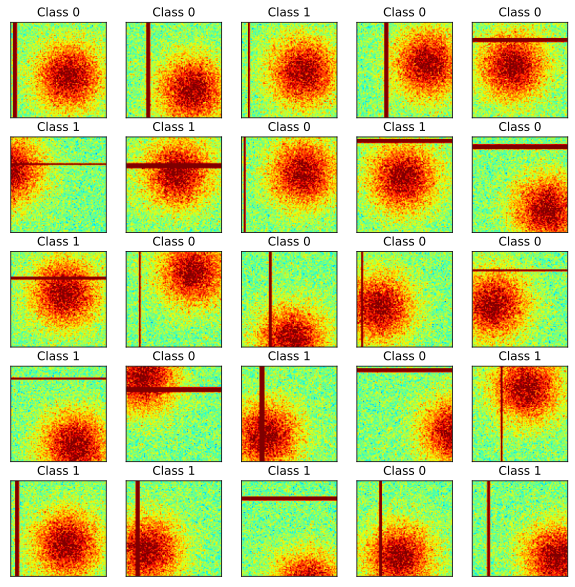

In [5]:
# visualize some images
fig,axs=plt.subplots(5,5,figsize=(10,10))

for i,ax in enumerate(axs.flatten()):
    whichpic=np.random.randint(2*nGauss)
    G=np.squeeze(images[whichpic,:,:])
    ax.imshow(G,vmin=-1,vmax=1,cmap="jet")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [6]:
# Create train/test groups using Dataloader

# step 2: use scikit-learn to split the data
train_data,test_data,train_labels,test_labels=train_test_split(images,images,test_size=0.1)

# step 3: convert to Pytorch Datasets
train_data=TensorDataset(train_data,train_labels)
test_data= TensorDataset(test_data,test_labels)

# step 4: translate into dataloader objects
batchsize=32
train_loader=DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [7]:
# check size (should be images x channels x width x height)
print(train_loader.dataset.tensors[0].shape)
print(train_loader.dataset.tensors[1].shape)

torch.Size([1800, 1, 91, 91])
torch.Size([1800, 1, 91, 91])


In [8]:
def outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,outChannels):
    Nh=int(np.floor((imgSize[0]+2*paddingSize[0]-kernelSize[0])/strideSize[0]))+1
    Nw=int(np.floor((imgSize[1]+2*paddingSize[1]-kernelSize[1])/strideSize[1]))+1
    return outChannels,(Nh,Nw),(int(Nh//poolSize[0]),int(Nw//poolSize[1]))

def fcInput(imgSize,inChannels):
    return int(imgSize[0]*imgSize[1]*inChannels)

In [9]:
# Create the DL model
def createNet(lr=0.001):
    input_img_channels=1
    convOutChannels=[6,4]
    imgSize=(91,91)
    kernelSize=(3,3)
    strideSize=(1,1)
    paddingSize=(1,1)
    poolSize=(2,2)
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### ENCODER: 

            # conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.conv1=nn.Conv2d(input_img_channels,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            
            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            ### DECODER:

            # trans-conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.t_conv1=nn.ConvTranspose2d(convOutChannels[1],convOutChannels[0],kernelSize,stride=poolSize)

            # trans-conv 2
            self.t_conv2=nn.ConvTranspose2d(convOutChannels[0],input_img_channels,kernelSize,stride=poolSize)



        def forward(self,x):
            ### Encoder

            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            pool1=F.avg_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(pool1))  
            
            # Latent/code/bottleneck layer output
            latentAct=F.avg_pool2d(conv2act,poolSize)
            
            ### Decoder

            # first trans-conv-pool set
            tconv1act=F.relu(self.t_conv1(latentAct))

            # second trans-conv-pool set
            output=self.t_conv2(tconv1act)

            return output,conv1act,conv2act,latentAct,tconv1act

    # create the model instance
    net=GaussNet()

    # loss function
    lossfun=nn.MSELoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer

In [10]:
# test the model with one batch
net,lossfun,optimizer=createNet()

X,y = next(iter(train_loader))
yHat,conv1act,conv2act,latentAct,tconv1act=net(X)

# check size of output
print('\nPredicted Category')
print(yHat.shape)
print('\nFeature maps after conv1')
print(conv1act.shape)
print('\nFeature maps after conv2')
print(conv2act.shape)

print('\nFeature Maps of latent layer')
print(latentAct.shape)
print('\nFeature maps after t-conv1')
print(tconv1act.shape)


# now let's compute the loss
loss=lossfun(yHat,y)
print(' ')
print('Loss: ')
print(loss)


Predicted Category
torch.Size([32, 1, 91, 91])

Feature maps after conv1
torch.Size([32, 6, 91, 91])

Feature maps after conv2
torch.Size([32, 4, 45, 45])

Feature Maps of latent layer
torch.Size([32, 4, 22, 22])

Feature maps after t-conv1
torch.Size([32, 6, 45, 45])
 
Loss: 
tensor(0.1718, grad_fn=<MseLossBackward0>)


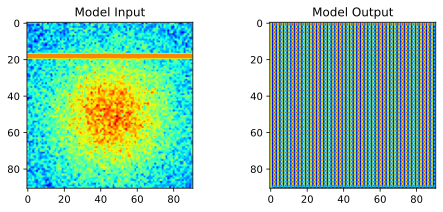

In [14]:
# lets see how they look
fig,ax=plt.subplots(1,2,figsize=(8,3))
ax[0].imshow(tr.squeeze(images[0,0,:,:]).detach(),cmap='jet')
ax[0].set_title('Model Input')
ax[1].imshow(tr.squeeze(yHat[0,0,:,:]).detach(),cmap='jet')
ax[1].set_title('Model Output')
plt.show()

In [11]:
# count the total number of parameters in the model
summary(net,(1,imgSize,imgSize))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 91, 91]              60
            Conv2d-2            [-1, 4, 45, 45]             220
   ConvTranspose2d-3            [-1, 6, 45, 45]             222
   ConvTranspose2d-4            [-1, 1, 91, 91]              55
Total params: 557
Trainable params: 557
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.03
Forward/backward pass size (MB): 0.60
Params size (MB): 0.00
Estimated Total Size (MB): 0.63
----------------------------------------------------------------


In [18]:
# Create a function that trains the model

def trainModel(n_epochs=500):
    # create a new model
    net,lossfun,optimizer=createNet()

    # send the model to the GPU
    net.to(device)

    # initialize losses
    trainLoss = tr.zeros(n_epochs)
    testLoss = tr.zeros(n_epochs)

    # loop over epochs
    for epochi in range(n_epochs):

        # loop over training data batches
        batchLoss=[]

        for X,y in train_loader:

            # push data to GPU
            X = X.to(device)
            y = y.to(device)

            # forward pass and loss
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # end of batch loop ...

        # and get the average losses across the batches
        trainLoss[epochi]=np.mean(batchLoss)

        # test accuracy
        X,y=next(iter(test_loader))
        # push data to GPU
        X = X.to(device)
        y = y.to(device)
        with tr.no_grad(): # deactivates autograd
            yHat=net(X)[0]
            loss=lossfun(yHat,y)

        # compare the following really long lines of code to the training accuracy lines
        testLoss[epochi]=loss.item()

    # end of epochs

    # function output
    return trainLoss,testLoss,net

In [16]:
# Run the model and show the results
trainLoss,testLoss,net=trainModel()

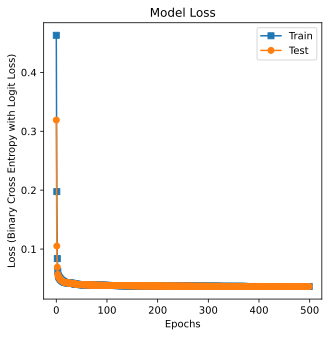

In [21]:
fig,ax=plt.subplots(1,1,figsize=(5,5))

ax.plot(trainLoss,'s-',label="Train")
ax.plot(testLoss,'o-',label="Test")
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Model Loss')
ax.legend()

plt.show()

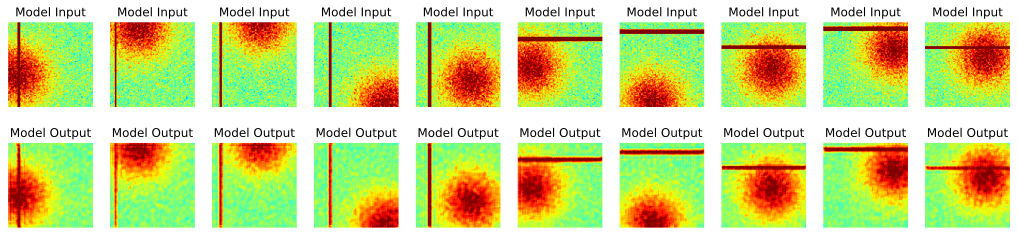

In [24]:
# visualize some images
X,y=next(iter(test_loader))
yHat=net(X)[0]

fig,axs=plt.subplots(2,10,figsize=(18,4))

for i in range(10):
    G=tr.squeeze(y[i,0,:,:]).detach()
    O=tr.squeeze(yHat[i,0,:,:]).detach()
    
    axs[0,i].imshow(G,vmin=-1,vmax=1,cmap="jet")
    axs[0,i].axis('off')
    axs[0,i].set_title('Model Input')
    axs[1,i].imshow(O,vmin=-1,vmax=1,cmap="jet")
    axs[1,i].axis('off')
    axs[1,i].set_title('Model Output')

plt.show()

**Additional Explorations**

In [ ]:
# 1) There are no test data here, so how do you know whether the model overfit the training set? Fortunately, you can simply create as much new data as you want! That's one of the advantages of generating data ; Generate a new dataset to use as a test set. How does the MSE loss compare on the test set? Did we overfit here? --> Done at start itself (it doesn't overfit)

# 2) The code here uses AvgPool. Are the results noticeably different if you use MaxPool instead?
# --> Not much difference
 
# 3) The final output doesn't have a nonlinearity (e.g., relu, sigmoid, tanh). Does it need one? Would that help? What are some arguments for and against having a nonlinear activation function on the output of the decover? Try adding one and see if it improves (via the final loss and visual inspection) the result.
# --> Used relu {not much difference}

# 4) I mentioned in the lecture "What are autoencoders and what do they do?" (section "Autoencoders") that BCEloss can be used when the data are between 0 and 1. Normalize the images so they are appropriately scaled, and then use BCEloss instead of MSEloss (does anything else in the model architecture need to change?). Which loss function gives a better result?
# --> In architecture, we need to normalize the output at the end of the forward propogation as BCELoss needs outputs to be between (0,1).
# --> Tried and found that even after 500 epochs loss saturates around 0.65. When outputs are visualized it is found that the one with BCELoss is more blurred as compared to MSELoss outputs


In [ ]:
### for 3 & 4
# Create the DL model
def createNet(lr=0.001):
    input_img_channels=1
    convOutChannels=[6,4]
    imgSize=(91,91)
    kernelSize=(3,3)
    strideSize=(1,1)
    paddingSize=(1,1)
    poolSize=(2,2)
    class GaussNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### ENCODER: 

            # conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.conv1=nn.Conv2d(input_img_channels,convOutChannels[0],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp1=outConvPoolSize(imgSize,kernelSize,strideSize,paddingSize,poolSize,convOutChannels[0])
            
            # conv 2
            self.conv2=nn.Conv2d(convOutChannels[0],convOutChannels[1],kernel_size=kernelSize,stride=strideSize,padding=paddingSize)
            self.outcp2=outConvPoolSize(self.outcp1[2],kernelSize,strideSize,paddingSize,poolSize,convOutChannels[1])

            ### DECODER:

            # trans-conv 1
            ### inChannels, outChannel, kernelSize, strideSize, paddingSize
            self.t_conv1=nn.ConvTranspose2d(convOutChannels[1],convOutChannels[0],kernelSize,stride=poolSize)

            # trans-conv 2
            self.t_conv2=nn.ConvTranspose2d(convOutChannels[0],input_img_channels,kernelSize,stride=poolSize)



        def forward(self,x):
            ### Encoder

            # first conv-pool set
            conv1act=F.relu(self.conv1(x))  
            pool1=F.max_pool2d(conv1act,poolSize)

            # second conv-pool set
            conv2act=F.relu(self.conv2(pool1))  
            
            # Latent/code/bottleneck layer output
            latentAct=F.max_pool2d(conv2act,poolSize)
            
            ### Decoder

            # first trans-conv-pool set
            tconv1act=F.relu(self.t_conv1(latentAct))

            # second trans-conv-pool set
            tconv2act=self.t_conv2(tconv1act)
            # output=F.relu(tconv2act)
            output=(tconv2act-tr.min(tconv2act))/(tr.max(tconv2act)-tr.min(tconv2act))


            return output,conv1act,conv2act,latentAct,tconv1act,tconv2act

    # create the model instance
    net=GaussNet()

    # loss function
    # lossfun=nn.MSELoss()
    lossfun=nn.BCELoss()

    # optimizer
    optimizer = tr.optim.Adam(net.parameters(),lr=lr)

    return net,lossfun,optimizer